# 340w food insecurity final code

### Loading the data sets and libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("maindataset.csv")
unemp = pd.read_excel('Unemployment Rate.xlsx') 
cpi   = pd.read_excel('cpi food at home.xlsx')  
fi    = pd.read_excel('food_insecurity_rates_usa.xlsx') 


C:\Users\fired\AppData\Local\Temp\ipykernel_28888\2006334354.py:11: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("maindataset.csv")


### Correlation Heat‑Map: Unemployment, Inflation, Food Insecurity

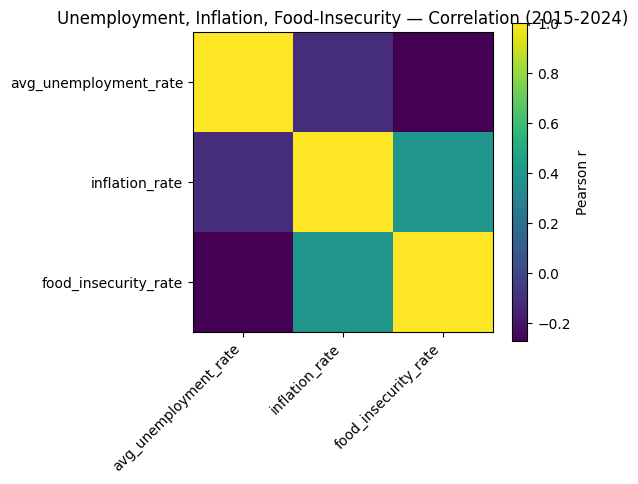

Correlation matrix:
                        avg_unemployment_rate  inflation_rate  \
avg_unemployment_rate                  1.000          -0.105   
inflation_rate                        -0.105           1.000   
food_insecurity_rate                  -0.272           0.394   

                       food_insecurity_rate  
avg_unemployment_rate                -0.272  
inflation_rate                        0.394  
food_insecurity_rate                  1.000   



In [12]:
#annual features 
unemp_yearly = unemp[['Year', 'avg_unemployment_rate']].copy()

cpi_yearly = (
    cpi[['Year', 'cpi_avg']]
    .sort_values('Year')
    .assign(inflation_rate=lambda d: d['cpi_avg'].pct_change() * 100)
)

fi_yearly = (
    fi[['Year', 'Food insecurity in households with children']]
    .rename(columns={'Food insecurity in households with children':
                     'food_insecurity_rate'})
)

#Merge totidy table
df = (unemp_yearly
      .merge(cpi_yearly[['Year', 'inflation_rate']], on='Year')
      .merge(fi_yearly, on='Year')
      .query('Year >= 2015')     
      .dropna())           

#Correlation heatmap
corr = df.drop(columns='Year').corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar(label='Pearson r')
plt.title('Unemployment, Inflation, Food-Insecurity — Correlation (2015-2024)')
plt.tight_layout()
plt.show()

print('Correlation matrix:\n', corr.round(3), '\n')

### Linear Regression: Test‑Set Fit

                             OLS Regression Results                             
Dep. Variable:     food_insecurity_rate   R-squared:                       0.999
Model:                              OLS   Adj. R-squared:                  0.996
Method:                   Least Squares   F-statistic:                     348.4
Date:                  Fri, 02 May 2025   Prob (F-statistic):             0.0379
Time:                          07:00:05   Log-Likelihood:                 6.6472
No. Observations:                     4   AIC:                            -7.294
Df Residuals:                         1   BIC:                            -9.135
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

C:\Users\fired\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


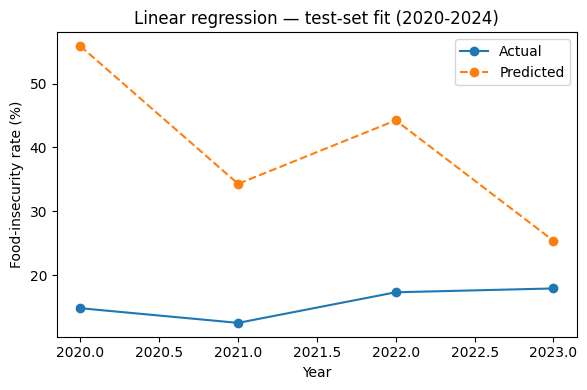

In [13]:
#time aware train / test split
train_df = df[df['Year'] <= 2019]   # pre covid
test_df  = df[df['Year'] >= 2020]   # post covid recovery

X_train = train_df[['avg_unemployment_rate', 'inflation_rate']]
y_train = train_df['food_insecurity_rate']

X_test  = test_df[['avg_unemployment_rate', 'inflation_rate']]
y_test  = test_df['food_insecurity_rate']

#intercept
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

#Fit OLS
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

#Predict & evaluate
y_pred = ols_model.predict(X_test_const)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f'\nTest RMSE: {rmse:.2f}')

#Plot predicted vs actual 
plt.figure(figsize=(6, 4))
plt.plot(test_df['Year'], y_test, marker='o', label='Actual')
plt.plot(test_df['Year'], y_pred, marker='o', linestyle='--', label='Predicted')
plt.xlabel('Year')
plt.ylabel('Food-insecurity rate (%)')
plt.title('Linear regression — test-set fit (2020-2024)')
plt.legend()
plt.tight_layout()
plt.show()


### Feature Importances For Predicting Food Insecurity

In [19]:
#create binary target
df["food_insecure"] = ((df["Sometimes not enough to eat"].fillna(0) +
                        df["Often not enough to eat"].fillna(0)) > 0).astype(int)

#Drop irrelevant columns
drop_cols = [
    "Enough of the kinds of food wanted",
    "Enough Food, but not always the kinds wanted",
    "Sometimes not enough to eat", 
    "Often not enough to eat", 
    "Did not report", 
    "week_name", "Year", "Location"
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

#fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())

#encode categorical columns
for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop("food_insecure", axis=1)
y = df["food_insecure"]

#split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#evaluate
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

#plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Predicting Food Insecurity")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

KeyError: 'Sometimes not enough to eat'